In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table, Column

from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
import astropy.units as u  

import astroplan
from astroplan import Observer, FixedTarget
from astroplan.plots import plot_airmass 


%matplotlib inline

def plot_mwd(ra,dec,label='',org=0,title='Mollweide projection', projection='mollweide'):
    x = np.remainder(ra+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=np.radians(-x)    # reverse the scale: East to the left
    y=np.radians(dec)
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection=projection, axisbg ='LightCyan')
    ax.scatter(x, y, marker='o', s=30, facecolor='red', edgecolor='', alpha=0.5)  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    for i, word in enumerate(label):
        ax.text(x[i]-1e-1, y[i]-2e-2, word, horizontalalignment='right') #('left' if i%2 else 'right'))
    ax.grid(True)

   name      ra     dec    N  distance
            deg     deg         Mpc   
--------- ------- ------- --- --------
 Sculptor   9.000 -31.000   8      2.8
   NGC908  35.750 -21.000   6     19.9
  NGC1052  40.000  -8.100   9     19.9
 Fornax I  53.000 -35.500  49     19.9
  NGC1433  57.750 -46.300  10     18.4
   Dorado  64.500 -55.800  19     19.9
  NGC2427 116.000 -50.000   5     12.3
  NGC2997 146.250 -31.100   8     12.3
    Leo I 165.500  13.000  14     10.7
  NGC4303 187.250   3.400  15     16.9
  Virgo I 188.000  11.500 177     15.9
  NGC4594 190.000 -11.100   8     15.3
  NGC4697 193.250  -7.400  25     16.9
  NGC4753 193.750   0.600   9     16.9
  NGC5128 201.250 -41.600  15      4.3
ESO221-26 213.000 -47.400   5     19.9
  NGC6744 286.000 -64.200   6     12.3


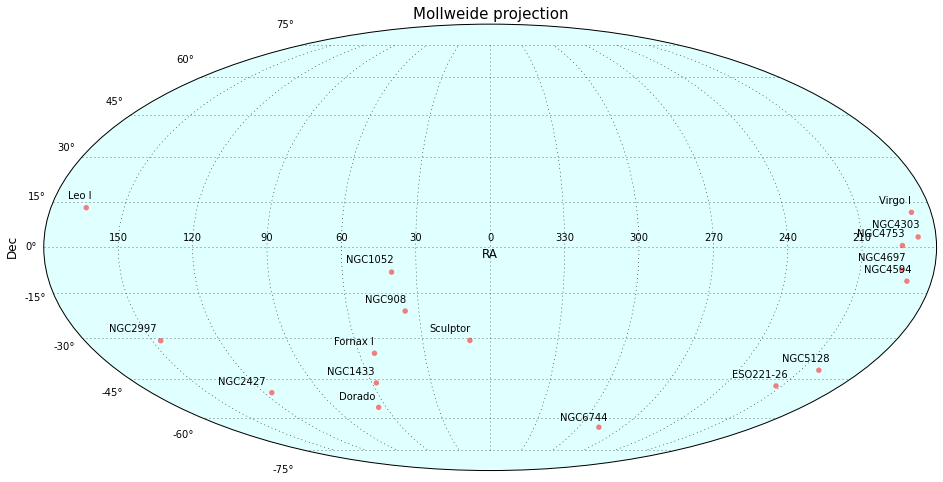

In [158]:
cat_file='data/Nearby galaxy groups - Fouque 1992.csv'
cat_data=Table.read(cat_file, format='csv')
cat_data['ra'].format = "%6.3f"
cat_data['dec'].format = "%6.3f"
cat_data['distance'].format = "%6.1f"
cat_data['ra'].unit = 'deg'
cat_data['dec'].unit = 'deg'
cat_data['distance'].unit = 'Mpc'

cat_data.sort('ra')

gv=((cat_data['dec']<15.) & (cat_data['distance']<20.) & (cat_data['N']>4))
cat_groups=cat_data[gv]

cat_groups[('name','ra','dec','N','distance')].pprint(max_lines=-1, max_width=-1) 
#print(cat_data[('name','ra','dec','N','distance')])
plot_mwd(cat_groups['ra'], cat_groups['dec'], label=cat_groups['name'])

In [159]:
ctio = Observer.at_site('ctio')
time = Time('2016-04-28 12:00:00')
airmass_limit=2.

#sunset_tonight = ctio.sun_set_time(time, which='nearest')
#sunrise_tonight = ctio.sun_rise_time(time, which='nearest')
set_astro = ctio.twilight_evening_astronomical(time)  
rise_astro = ctio.twilight_morning_astronomical(time, which='next')  
midnight = ctio.midnight(time)  

print 'Twilight evening UT : ', set_astro.iso
print 'Twilight morning UT : ', rise_astro.iso 
print 'Midnight UT : ', midnight.iso 

time_range=Time([set_astro.iso,rise_astro.iso], format='iso')
constraints = [astroplan.AltitudeConstraint(10*u.deg, 90*u.deg), astroplan.AirmassConstraint(airmass_limit), astroplan.AtNightConstraint.twilight_astronomical()]
targets = [FixedTarget(coord=SkyCoord(ra=ra*u.deg, dec=dec*u.deg), name=name)
           for name, ra, dec in cat_groups[('name','ra','dec')]]

ever_observable = astroplan.is_observable(constraints, ctio, targets, time_range=time_range)
always_observable = astroplan.is_always_observable(constraints, ctio, targets, time_range=time_range)

cat_groups['observability']=ever_observable
#cat_groups['set_time']=[ctio.target_set_time(time, FixedTarget(coord=SkyCoord(ra=ra*u.deg, dec=dec*u.deg), name=name))
#                        for name, ra, dec in cat_groups[('name','ra','dec')]]
#bv=np.where(cat_groups['set_time']<Time(0., format='jd'))
#cat_groups['set_time'][bv]=Time(1e10, format='jd')

observability_table = Table()
observability_table['targets'] = cat_groups['name']
observability_table['ever_observable'] = ever_observable
observability_table['always_observable'] = always_observable
print
print(observability_table)

Twilight evening UT :  2016-04-28 23:34:19.084
Twilight morning UT :  2016-04-29 09:54:50.789
Midnight UT :  2016-04-28 04:44:38.344

 targets  ever_observable always_observable
--------- --------------- -----------------
 Sculptor           False             False
   NGC908           False             False
  NGC1052           False             False
 Fornax I           False             False
  NGC1433           False             False
   Dorado           False             False
  NGC2427            True             False
  NGC2997            True             False
    Leo I            True             False
  NGC4303            True             False
  Virgo I            True             False
  NGC4594            True             False
  NGC4697            True             False
  NGC4753            True             False
  NGC5128            True             False
ESO221-26            True             False
  NGC6744            True             False


Column was already in the table
   name      ra     dec   observability       time_airmass     
            deg     deg                                        
--------- ------- ------- ------------- -----------------------
 Fornax I  53.000 -35.500         False           2457507.48217
  NGC1433  57.750 -46.300         False           2457507.48217
   Dorado  64.500 -55.800         False           2457507.49467
  NGC2427 116.000 -50.000          True           2457507.63217
    Leo I 165.500  13.000          True           2457507.67383
   NGC908  35.750 -21.000         False            2457507.6905
  NGC2997 146.250 -31.100          True           2457507.69467
  NGC1052  40.000  -8.100         False             2457507.703
  Virgo I 188.000  11.500          True            2457507.7405
  NGC4303 187.250   3.400          True           2457507.75717
  NGC4753 193.750   0.600          True           2457507.78217
  NGC4594 190.000 -11.100          True            2457507.7905
  NGC469

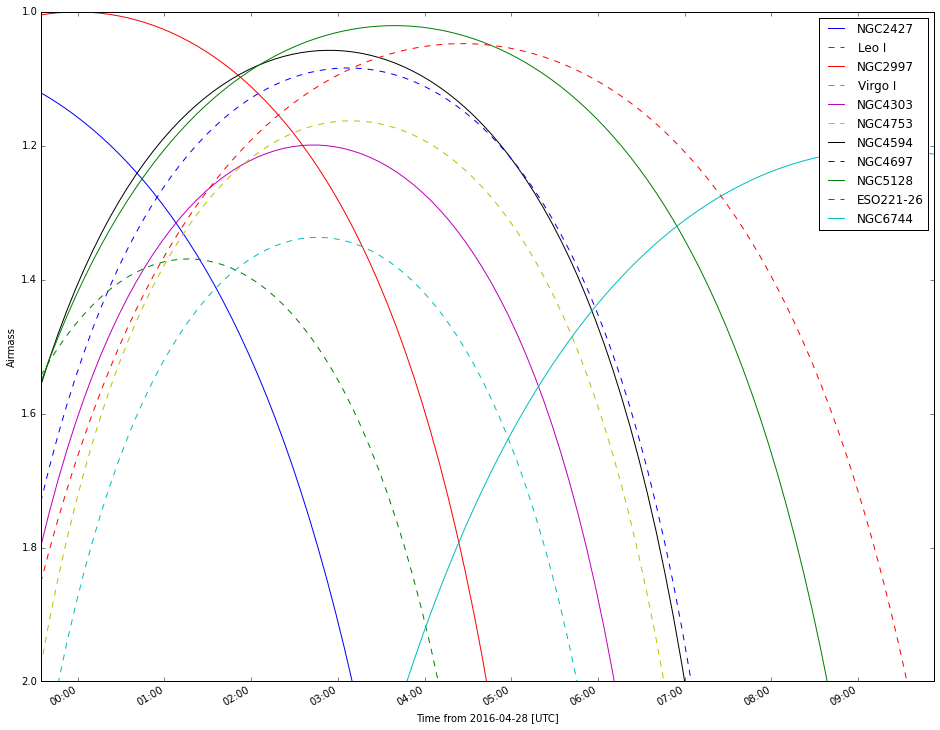

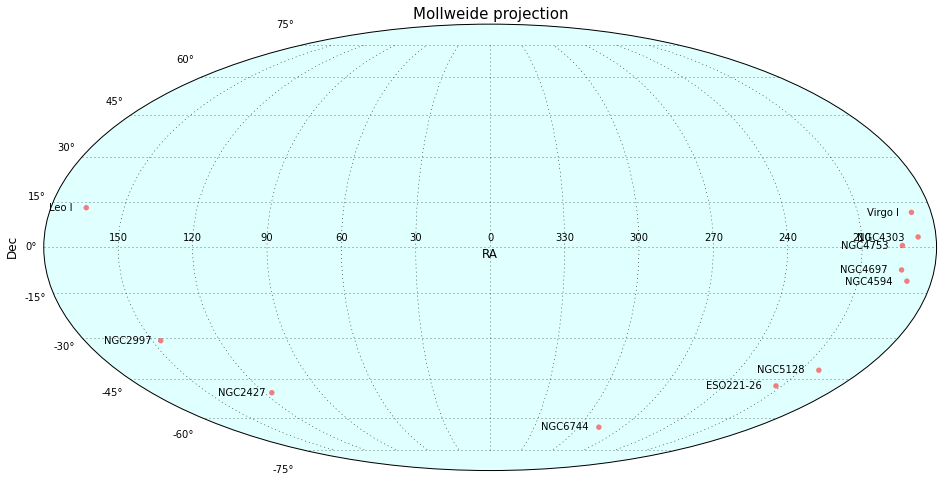

In [184]:
try:
    cat_groups.add_column(Column( Time(np.zeros(len(cat_groups)), format='jd'), name='time_airmass'))
except:
    print 'Column was already in the table'

plot_time_range=astroplan.time_grid_from_range(time_range, time_resolution=0.1*u.hour)

for i in range(len(cat_groups)):
    coo = SkyCoord(cat_groups['ra'][i]*u.deg, cat_groups['dec'][i]*u.deg, frame='icrs')
    target = FixedTarget(name=cat_groups['name'][i], coord=coo)
    airmass=ctio.altaz(plot_time_range, target).secz
    gv_peak=np.argmin( np.abs(airmass-1.) )
#    print gv_peak, len(airmass)
    if gv_peak<(len(airmass)-1):
        gv_limit=np.argmin( np.abs(airmass[gv_peak:-1]-airmass_limit) )
#        print gv_peak, gv_limit, plot_time_range[gv_peak:-1][gv_limit]
        cat_groups['time_airmass'][i]=plot_time_range[gv_peak:-1][gv_limit]
    else:
        cat_groups['time_airmass'][i]=time_range[1]
    
cat_groups.sort('time_airmass')
cat_groups[('name','ra','dec','observability','time_airmass')].pprint(max_lines=-1, max_width=-1) 

fig=plt.figure(figsize=(16,12))
fig, ax = plt.subplots(1,1,figsize=(16,12))
ax.set_yscale("linear")

style1= {'linestyle': '-'}
style2= {'linestyle': '--'}
style=style1

for i in range(len(cat_groups)):
    if cat_groups['observability'][i]==True:
        coo = SkyCoord(cat_groups['ra'][i]*u.deg, cat_groups['dec'][i]*u.deg, frame='icrs')
        target = FixedTarget(name=cat_groups['name'][i], coord=coo)
        plot_airmass(target, ctio, plot_time_range, style_kwargs=style)
        if style==style1:
            style=style2
        else:
            style=style1

ax.set_ylim(2.,1.)
plt.legend(loc=1, bbox_to_anchor=(1, 1)) 
plt.show() 

gv=(cat_groups['observability']==True)
plot_mwd(cat_groups['ra'][gv], cat_groups['dec'][gv], label=cat_groups['name'][gv])

In [53]:
astroplan.plots.available_style_sheets

[u'light_style_sheet', u'dark_style_sheet']